### DATA COLLECTION

In [ ]:
# Necessary Imports
from flask import Flask, jsonify
from werkzeug.routing import IntegerConverter
from _csv import Dialect as _Dialect
import copy
import csv
import os
from lib.rtls_slave import pixel_calculate, aoa_main, sort_data
import json


ENVIRONMENT = 'random'

# Handle Negative Values
class SignedIntConverter(IntegerConverter):
    regex = r'-?\d+'
app = Flask(__name__)
app.url_map.converters['signed_int'] = SignedIntConverter
#Store input values: AoA and Horizontal Angle

aoabefore = {}
aoa= {}
lev = []

@app.route('/')
def home():
    return "This is the HomePage"

#Routing Settings
@app.route('/send/<signed_int:horiz>', methods=['GET'])
def get_angle(horiz):
    global aoa
    global aoabefore
    
    print("Plane Angle: " + str(horiz))
    aoa_result = aoa_main()
    print(aoa_result)
    input_letter = input("If you want to add this data to list type 'y', otherwise press Enter")
    if input_letter!='y':
        return jsonify({'state':'Try Again'})
    lev.append(horiz)
    aoabefore = copy.deepcopy(aoa)
    aoa = aoa_result

    with open(f"./data/aoa_data/{ENVIRONMENT}_{horiz}.json",'w') as f:
        json.dump(aoa_result, f)
        
    return jsonify({'state': 'success'})

@app.route('/calculate/', methods=['GET'])
def calculate():

    u = []
    v = []

    # ANGLE SORTING TECHNIQUES
    aoabefore_ = sort_data(aoabefore,aoa_bias = -35)
    aoa_ = sort_data(aoa,aoa_bias = -35)

    print("Before Turning："+str(aoabefore)+'\n'+"After Turning： " + str(aoa) +'\n'+"Rotation Angle： "+ str(lev))
    set_aoa = set(aoa_)
    set_aoabefore = set(aoabefore_)

    for slave in set_aoa.intersection(set_aoabefore):
        f = open(f"./results/pixels/{slave.replace(':','_')}.csv",'w',newline="")
        f.truncate()
        writer = csv.writer(f)
        
        for i in range(len(aoabefore_[slave])):
            for j in range(len(aoa_[slave])):
                (temp1, temp2) = pixel_calculate(lev[-2] - lev[-1], aoabefore_[slave][i], aoa_[slave][j])

                if (temp1 != 1):
                    u.append(temp1)
                    v.append(temp2)
                    tupx = (temp1,temp2)
                    writer.writerow(tupx)
                
        
        f.close()

    
    return jsonify({'state': 'success'})

In [ ]:
ENVIRONMENT = 'two_top_outtest'
app.run(host='0.0.0.0',port = 5000, debug=False)
# My Charger: 80:6F:B0:EE:AD:32 : Water Bottle.
# Ishrath Charger:  80:6F:B0:EE:AA:13 : Tea Bottle.

### POST POINT CALCULATION

In [14]:
from lib.rtls_slave import post_calculation

# POST-ANALYSIS
post_calculation('two_down_outdoor',82,90,aoa_bias=6)

Before Turning：{'80:6F:B0:EE:AD:32': array([-12, -14, -14, -13, -13, -13, -13, -16, -16]), '80:6F:B0:EE:AA:13': array([17, 17, 16, 15, 14, 14, 15, 15, 16, 16, 16, 15, 14, 14, 15, 16, 18,
       18, 18, 16, 15, 14, 14, 14])}
After Turning： {'80:6F:B0:EE:AA:13': array([12, 12, 13, 13, 12, 13, 14, 15, 15, 16, 16, 16, 15, 14, 13, 13, 13,
       13, 14, 14, 14, 13, 12]), '80:6F:B0:EE:AD:32': array([-7, -5, -4, -5, -6, -6, -7, -7, -7])}
Rotation Angle： [82, 90]


f:\intern_VisBLE\VisBLE_INTERN\codes\lib\rtls_slave.py:274: RuntimeWarning: invalid value encountered in arccos
  azimuth_angle = np.arccos(np.cos(angle1) / np.sin(elevation_angle))


### VISUALIZING THE ANGLE

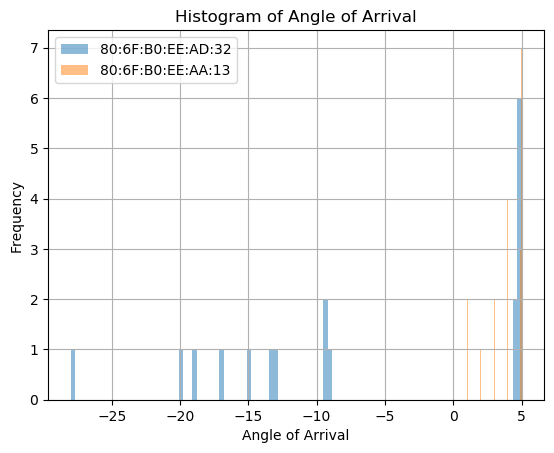

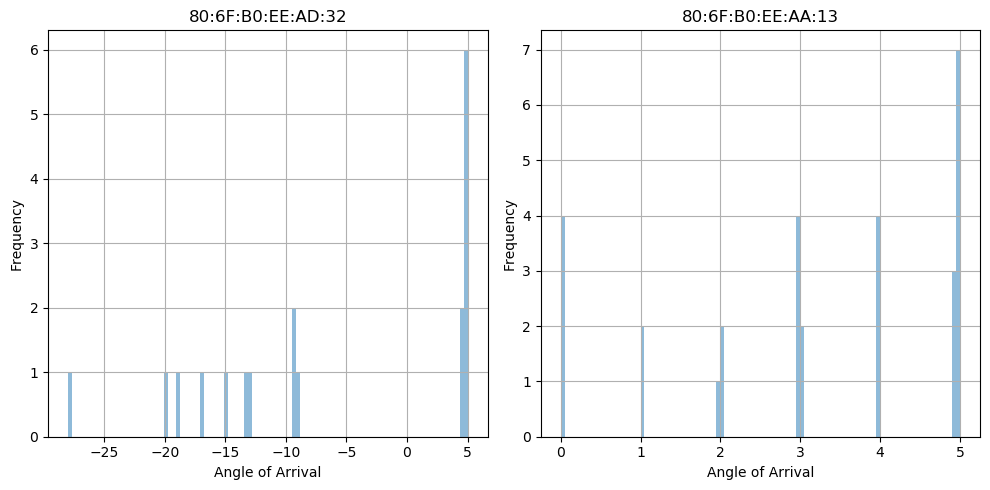

'SUCCESS'

In [2]:
from lib.rtls_slave import visualize_aoa_spread

CASE = 'two_down_outdoor'
level = 88
n_bins = 100
visualize_aoa_spread(CASE, level, n_bins)

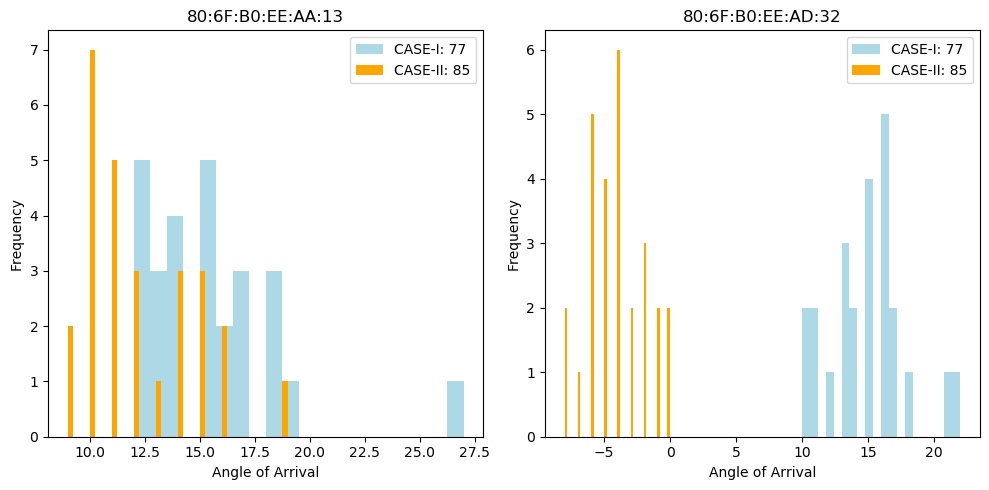

In [8]:
from lib.rtls_slave import visualize_aoa_turn_spread

CASE = 'two_down_outtest'
level1 = 77
level2 = 85
vis_bias = 0
nbins = 20

visualize_aoa_turn_spread(CASE, level1, level2, vis_bias, nbins)